In [128]:
'''
File name: preprocessing.ipynb
Authors: Yasmin El Euch, Aliénor Bénédicte G Hamoir, Clara Rossignol, Guillaume David E. Ryelandt
Date created: 04/11/2022
Date last modified: 06/11/2022
Python version: 3.8.8
'''

'\nFile name: preprocessing.ipynb\nAuthors: Yasmin El Euch, Aliénor Bénédicte G Hamoir, Clara Rossignol, Guillaume David E. Ryelandt\nDate created: 04/11/2022\nDate last modified: 06/11/2022\nPython version: 3.8.8\n'

In [129]:
#Imports used in this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [130]:
data_folder = 'data/'

In [131]:
print("Reading in movie data")

# Read in movie metadata and plot summaries
movie_headers = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie name','Movie release date','Movie box office revenue',
                 'Movie runtime','Movie languages','Movie countries','Movie genres']
plot_headers = ['Wikipedia movie ID','Plot Summary']
character_headers = ['Wikipedia movie ID', 'Freebase movie ID','Movie release date','Character name','Actor date of birth',
                     'Actor gender','Actor height','Actor ethnicity','Actor name','Actor age at movie release',
                     'Freebase character/actor map ID','Freebase character ID','Freebase actor ID']

movie_metadata = pd.read_csv(data_folder + 'movie.metadata.tsv',sep='\t',header=None,names=movie_headers,index_col=0)
plot_summaries = pd.read_csv(data_folder + 'plot_summaries.txt',sep='\t',index_col=0,names=plot_headers)
character_metadata = pd.read_csv(data_folder + 'character.metadata.tsv',sep='\t',header=None,names=character_headers,index_col='Wikipedia movie ID')

Reading in movie data


In [132]:
movie_metadata.head()

,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
Wikipedia movie ID,,,,,,,,
975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [133]:
plot_summaries.head()

,Plot Summary
Wikipedia movie ID,
23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
31186339,The nation of Panem consists of a wealthy Capi...
20663735,Poovalli Induchoodan is sentenced for six yea...
2231378,"The Lemon Drop Kid , a New York City swindler,..."
595909,Seventh-day Adventist Church pastor Michael Ch...


In [134]:
character_metadata.head()

,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
Wikipedia movie ID,,,,,,,,,,,,
975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [135]:
print("Movies with biggest box office revenues:")
movie_metadata.sort_values('Movie box office revenue', ascending = False).head()

Movies with biggest box office revenues:


,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
Wikipedia movie ID,,,,,,,,
4273140,/m/0bth54,Avatar,2009-12-10,2.782275e+09,178.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
52371,/m/0dr_4,Titanic,1997-11-01,2.185372e+09,194.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/09c7w0"": ""United States of America""}","{""/m/0fx2s"": ""Tragedy"", ""/m/04xvh5"": ""Costume ..."
22114132,/m/062zm5h,The Avengers,2012-04-11,1.511758e+09,137.0,"{""/m/06b_j"": ""Russian Language"", ""/m/02h40lc"":...","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ..."
31941988,/m/0gvsynb,Harry Potter and the Deathly Hallows – Part 2,2011-07-07,1.328111e+09,130.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/07s9rl0"": ""Drama"", ""/m/02n4kr"": ""Mystery""..."
25001260,/m/0872p_c,Transformers: Dark of the Moon,2011-06-23,1.123747e+09,157.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3mt0"": ""Alien Film"", ""/m/06n90"": ""Scie..."


In [136]:
print("What is needed to be processed:")
print("Rows with actor age at movie release under or equal to 0: %d" %len(character_metadata[character_metadata['Actor age at movie release']<=0]))
print("Rows with actor height under or equal to 0: %d" %len(character_metadata[character_metadata['Actor height']<=0]))
print("Rows with movie runtime under or equal to 0: %d" %len(movie_metadata[movie_metadata['Movie runtime']<=0]))

What is needed to be processed:
Rows with actor age at movie release under or equal to 0: 433
Rows with actor height under or equal to 0: 0
Rows with movie runtime under or equal to 0: 1


In [137]:
movie_metadata.isna().sum()

Freebase movie ID               0
Movie name                      0
Movie release date           6902
Movie box office revenue    73340
Movie runtime               20450
Movie languages                 0
Movie countries                 0
Movie genres                    0
dtype: int64

In [138]:
character_metadata.isna().sum()

Freebase movie ID                       0
Movie release date                   9995
Character name                     257875
Actor date of birth                106145
Actor gender                        45609
Actor height                       295845
Actor ethnicity                    344611
Actor name                           1228
Actor age at movie release         158113
Freebase character/actor map ID         0
Freebase character ID              257865
Freebase actor ID                     815
dtype: int64

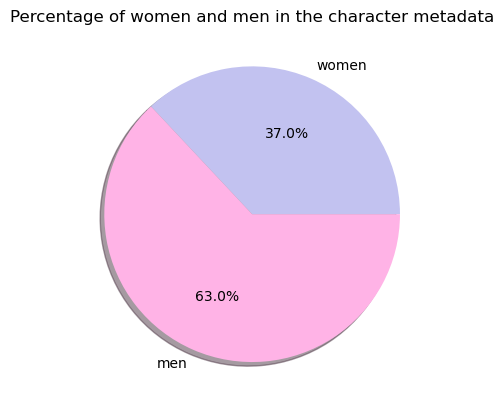

In [139]:
fem_act = character_metadata[character_metadata['Actor gender'] == 'F']
masc_act = character_metadata[character_metadata['Actor gender'] == 'M']
plt.pie(np.array([fem_act['Actor name'].nunique(),masc_act['Actor name'].nunique()]),labels=['women','men'],colors = ['#c2c2f0','#ffb3e6'],autopct='%1.1f%%',shadow=True)
plt.title('Percentage of women and men in the character metadata')
plt.show()